# Антикризовий проект з курсу "Управління ризиками"

Підготували студенти групи КА-22мп: 

* Кавара Артем 

* Макухін Євген 

* Яковина Андрій

#### Імпорти

In [7]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc
import numpy as np
import xgboost as xgb
import time
import joblib

In [3]:
print('The scikit-learn version is {}.'.format(xgb.__version__))

The scikit-learn version is 1.6.2.


In [8]:
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from joblib import dump, load
from dask.distributed import Client
from imblearn.pipeline import make_pipeline as make_pipeline_im
from imblearn.over_sampling import SMOTENC

In [9]:
plt.style.use('seaborn-white')

In [10]:
pd.set_option('display.float_format','{:.6f}'.format)

In [11]:
fraud_train = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv", index_col=0)
fraud_test = pd.read_csv("/kaggle/input/fraud-detection/fraudTest.csv", index_col=0)

In [8]:
fraud_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.230600,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.420700,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


#### Перетворення деяких колонок у інший тип даних

In [12]:
fraud_train['category'] = fraud_train['category'].astype('category')
fraud_train['gender'] = fraud_train['gender'].astype('category')
fraud_train['job'] = fraud_train['job'].astype('category')
fraud_train['state'] = fraud_train['state'].astype('category')

fraud_train['trans_date_trans_time'] = fraud_train['trans_date_trans_time'].astype('datetime64')
fraud_train['dob'] = fraud_train['dob'].astype('datetime64')

fraud_train['is_fraud'] = fraud_train['is_fraud'].astype('category')

temp = fraud_train.trans_date_trans_time - fraud_train.dob
fraud_train['age_days'] = temp.apply(lambda elem: elem.days)

fraud_train['date'] = fraud_train['trans_date_trans_time'].apply(lambda elem: elem.date())
fraud_train['time'] = fraud_train['trans_date_trans_time'].apply(lambda elem: elem.time())

fraud_train['time_in_sec'] = fraud_train.time.apply(lambda elem: int(elem.hour)*60*60+int(elem.minute)*60+int(elem.second))

In [10]:
job_stat = fraud_train.job.value_counts().sort_values(ascending=False)

In [41]:
job_stat

Film/video editor             9779
Exhibition designer           9199
Naval architect               8684
Surveyor, land/geomatics      8680
Materials engineer            8270
                              ... 
Information officer              8
Veterinary surgeon               8
Warehouse manager                7
Ship broker                      7
Contracting civil engineer       7
Name: job, Length: 494, dtype: int64

In [42]:
job_stat.describe()

count    494.000000
mean    2624.848178
std     1858.791304
min        7.000000
25%     1058.250000
50%     2087.500000
75%     3600.250000
max     9779.000000
Name: job, dtype: float64

In [43]:
job_stat.shape

(494,)

In [44]:
job_stat[job_stat < 1000].shape

(78,)

In [10]:
x_cols = ['category', 'amt', 'gender', 'state', 'city_pop', 'age_days', 'time_in_sec']
y_col = ['is_fraud']

In [11]:
fraud_train_adj = fraud_train[x_cols+y_col].copy()
fraud_train_adj

,category,amt,gender,state,city_pop,age_days,time_in_sec,is_fraud
0,misc_net,4.970000,F,NC,3495,11255,18,0
1,grocery_pos,107.230000,F,WA,149,14804,44,0
2,entertainment,220.110000,M,ID,4154,20801,51,0
3,gas_transport,45.000000,M,MT,1939,18982,76,0
4,misc_pos,41.960000,M,VA,99,11967,186,0
...,...,...,...,...,...,...,...,...
1296670,entertainment,15.560000,M,UT,258,21394,43928,0
1296671,food_dining,51.700000,M,MD,100,14803,43939,0
1296672,food_dining,105.930000,M,NM,899,19289,43952,0
1296673,food_dining,74.900000,M,SD,1126,14552,44016,0


In [14]:
fraud_train_adj['job'] = fraud_train_adj['job'].apply(lambda elem: 'other' if elem in job_stat[job_stat < 1000].index else elem)
fraud_train_adj.job = fraud_train_adj.job.astype('category')

In [12]:
categorical_vars = ['category', "gender", "state"]
regr_vars = ['amt', 'city_pop', 'age_days', 'time_in_sec']

In [13]:
X_train = fraud_train_adj[x_cols]
y_train = fraud_train_adj[y_col]
y_train = y_train.to_numpy().reshape(fraud_train_adj.shape[0],)

In [14]:
fraud_test['category'] = fraud_test['category'].astype('category')
fraud_test['gender'] = fraud_test['gender'].astype('category')
fraud_test['job'] = fraud_test['job'].astype('category')
fraud_test['state'] = fraud_test['state'].astype('category')

fraud_test['trans_date_trans_time'] = fraud_test['trans_date_trans_time'].astype('datetime64')
fraud_test['dob'] = fraud_test['dob'].astype('datetime64')

fraud_test['is_fraud'] = fraud_test['is_fraud'].astype('category')

temp = fraud_test.trans_date_trans_time - fraud_test.dob
fraud_test['age_days'] = temp.apply(lambda elem: elem.days)
fraud_test['date'] = fraud_test['trans_date_trans_time'].apply(lambda elem: elem.date())
fraud_test['time'] = fraud_test['trans_date_trans_time'].apply(lambda elem: elem.time())

fraud_test['time_in_sec'] = fraud_test.time.apply(lambda elem: int(elem.hour)*60*60+int(elem.minute)*60+int(elem.second))

fraud_test_adj = fraud_test[x_cols+y_col].copy()
fraud_test_adj

,category,amt,gender,state,city_pop,age_days,time_in_sec,is_fraud
0,personal_care,2.860000,M,SC,333497,19087,44065,0
1,personal_care,29.840000,F,UT,302,11113,44073,0
2,health_fitness,41.280000,F,NY,34496,18141,44093,0
3,misc_pos,60.050000,M,FL,54767,12020,44115,0
4,travel,3.190000,M,MI,1126,23727,44117,0
...,...,...,...,...,...,...,...,...
555714,health_fitness,43.770000,M,MO,519,20045,86347,0
555715,kids_pets,111.840000,M,TX,28739,7675,86349,0
555716,kids_pets,86.880000,F,WA,3684,14277,86355,0
555717,travel,7.990000,M,ID,129,20105,86364,0


In [18]:
fraud_test_adj['job'] = fraud_test_adj['job'].apply(lambda elem: 'other' if elem not in job_stat[job_stat >= 1000].index else elem)
fraud_test_adj.job = fraud_test_adj.job.astype('category')

In [15]:
X_test = fraud_test_adj[x_cols]
y_test = fraud_test_adj[y_col]
y_test = y_test.to_numpy().reshape(fraud_test_adj.shape[0],)

In [16]:
def create_encoder(categorical_vars = categorical_vars, regr_vars = regr_vars):
    return make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_vars),
        (StandardScaler(),regr_vars))

### Cross-validation для тьюнінгу параметрів XGBoost

In [34]:
fix_params = {'objective': 'binary:logistic',
             'scale_pos_weight': 10,
             'tree_method':'gpu_hist',
             'predictor' : 'gpu_predictor',
             'gpu_id' : 0}

In [64]:
cv_params = {'eta': [0, 0.01, 0.1], 
             'max_delta_step': [0,1,2,3],
            'learning_rate': [0, 0.01, 0.1]}

In [65]:
client = Client(processes=False)

xgb_cl = xgb.XGBClassifier(**fix_params)
column_transformer = create_encoder()
sm = SMOTENC(categorical_features=[X_train.dtypes=='category'], sampling_strategy = 1/100)
pca = PCA(n_components = 0.95)
grid_search = GridSearchCV(estimator=xgb_cl, 
                           param_grid=cv_params, 
                           cv=2,
                           scoring=['roc_auc','recall', 'f1'],
                           verbose=1,
                           refit='roc_auc'
                          )
xgb_cl_pipeline = Pipeline([
    ('encoding',column_transformer),
    ('pca', pca),
    ('grid_search', grid_search)
])

pipeline_with_resampling = make_pipeline_im(sm, xgb_cl_pipeline)

/opt/conda/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37331 instead
  f"Port {expected} is already in use.\n"


In [66]:
with joblib.parallel_backend('dask'):
    pipeline_with_resampling.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [68]:
grid_search.cv_results_['mean_test_recall'] 

array([0.        , 0.        , 0.        , 0.        , 0.77170067,
       0.71693382, 0.77154551, 0.77154551, 0.8191766 , 0.81234981,
       0.81584076, 0.81832321, 0.        , 0.        , 0.        ,
       0.        , 0.77170067, 0.71693382, 0.77154551, 0.77154551,
       0.8191766 , 0.81234981, 0.81584076, 0.81832321, 0.        ,
       0.        , 0.        , 0.        , 0.77170067, 0.71693382,
       0.77154551, 0.77154551, 0.8191766 , 0.81234981, 0.81584076,
       0.81832321])

In [70]:
grid_search.cv_results_['mean_test_f1'] 

array([0.        , 0.        , 0.        , 0.        , 0.69160725,
       0.65982798, 0.69093393, 0.69112515, 0.78789352, 0.7714012 ,
       0.78365907, 0.78889289, 0.        , 0.        , 0.        ,
       0.        , 0.69160725, 0.65982798, 0.69093393, 0.69112515,
       0.78789352, 0.7714012 , 0.78365907, 0.78889289, 0.        ,
       0.        , 0.        , 0.        , 0.69160725, 0.65982798,
       0.69093393, 0.69112515, 0.78789352, 0.7714012 , 0.78365907,
       0.78889289])

In [71]:
grid_search.cv_results_['mean_test_roc_auc']

array([0.5       , 0.5       , 0.5       , 0.5       , 0.95837556,
       0.90519187, 0.95826609, 0.95826853, 0.97800686, 0.97726956,
       0.97796835, 0.97846587, 0.5       , 0.5       , 0.5       ,
       0.5       , 0.95837556, 0.90519187, 0.95826609, 0.95826853,
       0.97800686, 0.97726956, 0.97796835, 0.97846587, 0.5       ,
       0.5       , 0.5       , 0.5       , 0.95837556, 0.90519187,
       0.95826609, 0.95826853, 0.97800686, 0.97726956, 0.97796835,
       0.97846587])

In [72]:
grid_search.cv_results_['params'] 

[{'eta': 0, 'learning_rate': 0, 'max_delta_step': 0},
 {'eta': 0, 'learning_rate': 0, 'max_delta_step': 1},
 {'eta': 0, 'learning_rate': 0, 'max_delta_step': 2},
 {'eta': 0, 'learning_rate': 0, 'max_delta_step': 3},
 {'eta': 0, 'learning_rate': 0.01, 'max_delta_step': 0},
 {'eta': 0, 'learning_rate': 0.01, 'max_delta_step': 1},
 {'eta': 0, 'learning_rate': 0.01, 'max_delta_step': 2},
 {'eta': 0, 'learning_rate': 0.01, 'max_delta_step': 3},
 {'eta': 0, 'learning_rate': 0.1, 'max_delta_step': 0},
 {'eta': 0, 'learning_rate': 0.1, 'max_delta_step': 1},
 {'eta': 0, 'learning_rate': 0.1, 'max_delta_step': 2},
 {'eta': 0, 'learning_rate': 0.1, 'max_delta_step': 3},
 {'eta': 0.01, 'learning_rate': 0, 'max_delta_step': 0},
 {'eta': 0.01, 'learning_rate': 0, 'max_delta_step': 1},
 {'eta': 0.01, 'learning_rate': 0, 'max_delta_step': 2},
 {'eta': 0.01, 'learning_rate': 0, 'max_delta_step': 3},
 {'eta': 0.01, 'learning_rate': 0.01, 'max_delta_step': 0},
 {'eta': 0.01, 'learning_rate': 0.01, 'max_d

In [53]:
grid_search

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'ccp_alpha': [0, 0.001, 0.01, 0.1],
                         'class_weight': ['balanced', None],
                         'verbose': [0, 1, 2, 3]},
             refit='roc_auc', scoring=['roc_auc', 'recall', 'f1'],
             verbose=True)

In [32]:
best_params = {
    'eta':0.0,
    'max_delta_step':3,
    'learning_rate':0.1,
}

In [35]:
client = Client(processes=False)
xgb_cl_best = xgb.XGBClassifier(**best_params, **fix_params, n_jobs=-1)
xgb_cl = xgb.XGBClassifier(**fix_params, number_of_jobs=-1)
column_transformer = create_encoder()
sm = SMOTENC(categorical_features=[X_train.dtypes=='category'], sampling_strategy = 1/100)
pca = PCA(n_components = 0.95)
xgb_cl_best_pipeline = Pipeline([
    ('encoding',column_transformer),
    ('pca', pca),
    ('xgb_best', xgb_cl_best)
])

pipeline_with_resampling_best = make_pipeline_im(sm, xgb_cl_best_pipeline)

/opt/conda/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37701 instead
  f"Port {expected} is already in use.\n"


In [36]:
%%time

with joblib.parallel_backend('dask'):
    pipeline_with_resampling_best.fit(X_train, y_train)

CPU times: user 1min 39s, sys: 26.7 s, total: 2min 5s
Wall time: 1min 40s


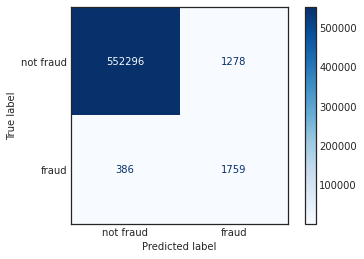

In [37]:
ConfusionMatrixDisplay.from_estimator(
        pipeline_with_resampling_best,
        X_test,
        y_test,
        display_labels = ['not fraud', 'fraud'],
        cmap=plt.cm.Blues,
);
plt.savefig("confusion-matrix-best.png", dpi=300)

In [38]:
print(classification_report(y_test, pipeline_with_resampling_best.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.58      0.82      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.79      0.91      0.84    555719
weighted avg       1.00      1.00      1.00    555719



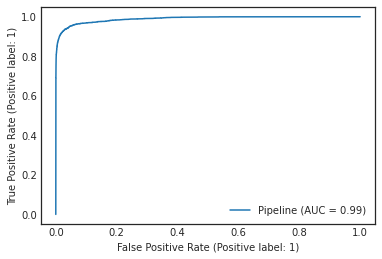

In [39]:
ax = plt.gca()
RocCurveDisplay.from_estimator(pipeline_with_resampling_best, X_test, y_test, ax=ax)
plt.savefig("roc.png", dpi=300)

In [40]:
dump(pipeline_with_resampling_best, 'pipeline_with_resampling_best.joblib')

['pipeline_with_resampling_best.joblib']

In [17]:
pipeline_with_resampling_best = load('/kaggle/input/model-joblib/pipeline_with_resampling_best.joblib')

In [54]:
pred_full = pipeline_with_resampling_best.predict(X_test)
pred_proba_full = pipeline_with_resampling_best.predict_proba(X_test)

In [42]:
scoring_df = pd.DataFrame([{
    "Accuracy": accuracy_score(y_test, pred_full),
    "Recall": recall_score(y_test, pred_full),
    "Precision": precision_score(y_test, pred_full),
    "F1": f1_score(y_test, pred_full),
    "ROC_AUC": roc_auc_score(y_test, pred_full)
}])

In [55]:
scoring_df

,Accuracy,Recall,Precision,F1,ROC_AUC
0,0.997006,0.820047,0.579190,0.678888,0.908869


In [25]:
pred_proba_full[(pred_full==1) & (y_test == 1)]

array([[1.8045306e-03, 9.9819547e-01],
       [1.3125837e-02, 9.8687416e-01],
       [9.7314119e-03, 9.9026859e-01],
       ...,
       [5.3423643e-04, 9.9946576e-01],
       [2.8028488e-03, 9.9719715e-01],
       [1.6008019e-03, 9.9839920e-01]], dtype=float32)

In [32]:
pipeline_with_resampling_best.predict_proba(pd.DataFrame([X_test[(pred_full==1) & (y_test == 1)].iloc[1]]))

array([[0.01312584, 0.98687416]], dtype=float32)

In [44]:
fn_pred = X_test[(pred_full==0) & (y_test == 1)]
tn_pred = X_test[(pred_full==1) & (y_test == 1)]

In [57]:
pd.DataFrame(fn_pred.amt.describe())

,amt
count,386.000000
mean,75.172461
std,170.334279
min,1.780000
25%,10.372500
50%,19.875000
75%,41.355000
max,1319.970000


In [65]:
X_test_copy = X_test.copy()
X_test_copy['pred'] = pred_full
X_test_copy['true'] = y_test

In [74]:
X_test_copy['is_suc'] = X_test_copy.apply(lambda elem: 1 if (elem.pred==0) and (elem.true == 1) else 0, axis=1)

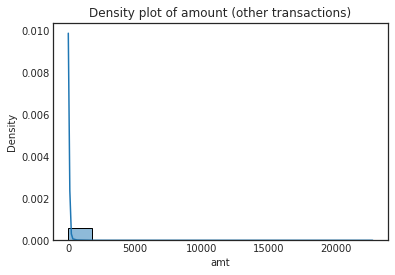

In [81]:
sns.histplot(fn_pred, x='amt', hue='is_suc', stat="density", kde=True, bins=13)
plt.title("Density plot of amount (successful vs other)")
plt.savefig("den-3.png", dpi=300)

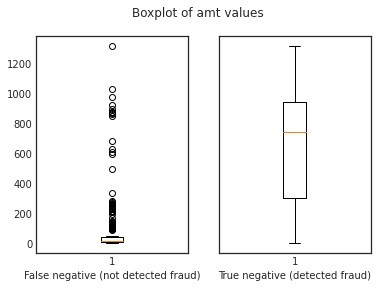

In [45]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.suptitle("Boxplot of amt values")
ax[0].boxplot(fn_pred.amt)
ax[0].set_xlabel("False negative (not detected fraud)");

ax[1].boxplot(tn_pred.amt)
ax[1].set_xlabel("True negative (detected fraud)");

plt.savefig("fn-tn-amt-best.png", dpi=300)

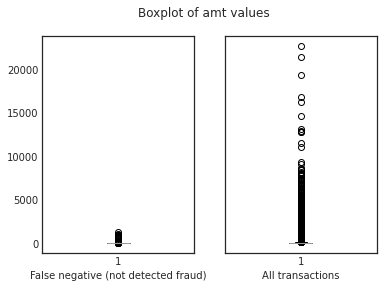

In [46]:
fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].boxplot(fn_pred.amt)
ax[0].set_xlabel("False negative (not detected fraud)");

ax[1].boxplot(X_test.amt)
ax[1].set_xlabel("All transactions");
fig.suptitle("Boxplot of amt values")
plt.savefig("fn-all-amt-best.png", dpi=300)

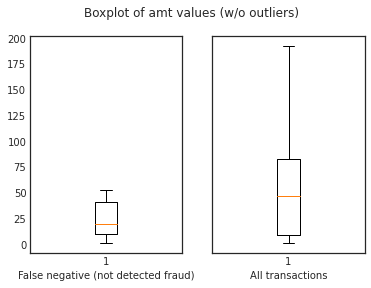

In [47]:
fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].boxplot(fn_pred.amt, showfliers=False)
ax[0].set_xlabel("False negative (not detected fraud)");

ax[1].boxplot(X_test.amt, showfliers=False)
ax[1].set_xlabel("All transactions");
fig.suptitle("Boxplot of amt values (w/o outliers)")
plt.savefig("fn-all-amt-wo-out-best.png", dpi=300)

In [85]:
sum(fn_pred.amt)/(sum(X_test.amt))*100

0.07524477583347446

## Завдання 2. Прогнозування часу наступної шахрайської операції

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend

In [40]:
fraud_df_2[fraud_df_2.Class == 1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.000000,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.000000,1
623,472.000000,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.000000,1
4920,4462.000000,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.930000,1
6108,6986.000000,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.000000,1
6329,7519.000000,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.000000,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.000000,1
280143,169347.000000,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.760000,1
280149,169351.000000,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.890000,1
281144,169966.000000,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.000000,1


In [58]:
%%time
fraud_unix_time = fraud_train[fraud_train.is_fraud == 1].unix_time

temp_unix_arr = []
i = 0
for ind,row in fraud_train.iterrows():
    if i == fraud_unix_time.shape[0]:
        break
    temp_unix_arr.append(fraud_unix_time.iloc[i])
    if row['is_fraud'] == 1: 
        i+=1

CPU times: user 1min 21s, sys: 1.07 s, total: 1min 23s
Wall time: 1min 23s


In [59]:
fraud_train_ts = fraud_train[0:1295734].copy()
fraud_train_ts['next_fraud'] = temp_unix_arr
fraud_train_ts['time_left_to_fraud'] = fraud_train_ts.apply(lambda elem: elem['next_fraud'] - elem['unix_time'], axis = 1)
fraud_train_ts

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,unix_time,merch_lat,merch_long,is_fraud,age_days,date,time,time_in_sec,next_fraud,time_left_to_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,1325376018,36.011293,-82.048315,0,11255,2019-01-01,00:00:18,18,1325466397,90379
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1325376044,49.159047,-118.186462,0,14804,2019-01-01,00:00:44,44,1325466397,90353
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,1325376051,43.150704,-112.154481,0,20801,2019-01-01,00:00:51,51,1325466397,90346
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1325376076,47.034331,-112.561071,0,18982,2019-01-01,00:01:16,76,1325466397,90321
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,1325376186,38.674999,-78.632459,0,11967,2019-01-01,00:03:06,186,1325466397,90211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295729,2020-06-21 03:58:54,6011706277606006,"fraud_Swaniawski, Lowe and Robel",shopping_pos,8.700000,Scott,Sullivan,M,776 Martin Ridge,Newton,...,1371787134,43.681749,-70.207213,0,24668,2020-06-21,03:58:54,14334,1371787186,52
1295730,2020-06-21 03:59:11,4908846471916297,fraud_Christiansen-Gusikowski,misc_pos,60.510000,Lauren,Torres,F,03030 White Lakes,Grandview,...,1371787151,33.006773,-96.927801,0,10194,2020-06-21,03:59:11,14351,1371787186,35
1295731,2020-06-21 03:59:21,30230540139182,fraud_Koepp-Witting,grocery_pos,103.400000,Hayden,Sanders,M,8465 Reed Green Suite 559,Montandon,...,1371787161,41.564577,-76.907169,0,16836,2020-06-21,03:59:21,14361,1371787186,25
1295732,2020-06-21 03:59:36,3590736522064285,fraud_Cummings Group,grocery_net,55.610000,Kimberly,Gonzalez,F,72966 Shannon Pass Apt. 391,Bauxite,...,1371787176,33.601124,-93.390782,0,16255,2020-06-21,03:59:36,14376,1371787186,10


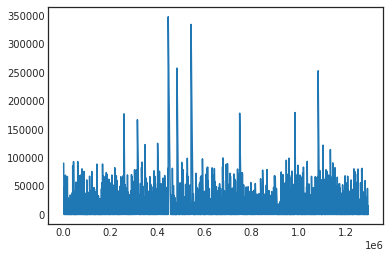

In [60]:
plt.plot(fraud_train_ts.time_left_to_fraud)

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [62]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [64]:
data_set = scaler.fit_transform(fraud_train_ts.time_left_to_fraud.to_numpy().reshape(-1, 1))

In [65]:
data_set

array([[2.59494271e-01],
       [2.59419620e-01],
       [2.59399522e-01],
       ...,
       [7.17794705e-05],
       [2.87117882e-05],
       [0.00000000e+00]])

In [66]:
train_size = int(len(data_set) * 0.67)
test_size = len(data_set) - train_size
train, test = data_set[0:train_size,:], data_set[train_size:len(data_set),:]

In [67]:
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)

In [73]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
with tf.device('/CPU:0'):
    model.fit(trainX, trainY, epochs=10, batch_size=128, verbose=2)

Epoch 1/10
6783/6783 - 20s - loss: 2.3834e-04
Epoch 2/10
6783/6783 - 17s - loss: 1.5559e-05
Epoch 3/10
6783/6783 - 18s - loss: 1.4657e-05
Epoch 4/10
6783/6783 - 17s - loss: 1.4310e-05
Epoch 5/10
6783/6783 - 17s - loss: 1.4166e-05
Epoch 6/10
6783/6783 - 18s - loss: 1.4124e-05
Epoch 7/10
6783/6783 - 17s - loss: 1.4035e-05
Epoch 8/10
6783/6783 - 17s - loss: 1.4006e-05
Epoch 9/10
6783/6783 - 17s - loss: 1.4001e-05
Epoch 10/10
6783/6783 - 18s - loss: 1.3940e-05


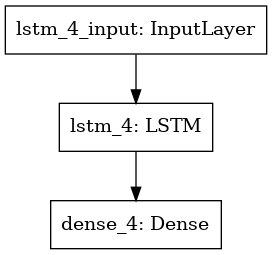

In [119]:
tf.keras.utils.plot_model(model)

In [75]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting

Train Score: 1285.34 RMSE
Test Score: 1249.99 RMSE


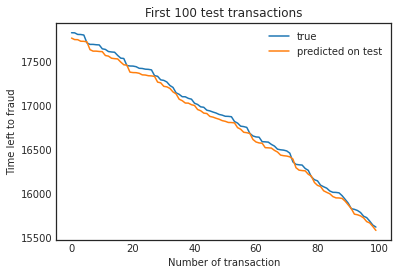

In [82]:
from matplotlib.pyplot import plot
plot(testY[0][:100], label = 'true')
plot(testPredict[:,0][:100], label = 'predicted on test')
plt.xlabel("Number of transaction")
plt.ylabel("Time left to fraud")
plt.legend()
#plt.show()
plt.title("First 100 test transactions")
plt.savefig("ts-2.png", dpi=300)

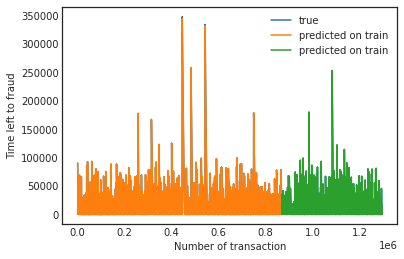

In [76]:
trainPredictPlot = np.empty_like(data_set)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_set)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(1*2)+1:len(data_set)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_set), label = 'true')
plt.plot(trainPredictPlot, label = 'predicted on train')
plt.plot(testPredictPlot, label = 'predicted on train')
plt.xlabel("Number of transaction")
plt.ylabel("Time left to fraud")
plt.legend()
#plt.show()
plt.savefig("ts-1.png", dpi=300)